In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem

In [17]:
df = pd.read_csv('data/as20000102.txt', sep='\s+', skiprows=[0,1,2])
df.columns = ['FromNodeId', 'ToNodeId', 'ExtraColumn']
df = df.drop(columns=['ExtraColumn'])
df
#structure that we want in each txt.file

,FromNodeId,ToNodeId
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
13890,6361,6361
13891,6390,6391
13892,6399,6399
13893,6402,6402


In [18]:
import os
#data structures for our ndoes and edges
directory_path = 'data/as'
nodes = set()
edges = {}

for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    if os.path.isfile(file_path) and filename.endswith('.txt'):
        #here, for formatting, it is easiest to skip the first four rows
        df = pd.read_csv(file_path, sep='\s+', skiprows=4, header=None, names=['FromNodeId', 'ToNodeId'])
        for index, row in df.iterrows():
            from_node, to_node = row['FromNodeId'], row['ToNodeId']
            nodes.add(from_node)
            nodes.add(to_node)
            edge = (from_node, to_node)
            if from_node != to_node: #don't include self-edges
                if edge in edges:
                    edges[edge] += 1
                else:
                    edges[edge] = 1
        


In [19]:

undirected_edges = {}
count =0

for (from_node, to_node), frequency in edges.items():
    reverse_edge = (to_node, from_node)
    if reverse_edge in edges:
        # Sort the nodes to maintain consistency (since (A, B) is the same as (B, A) in undirected graphs)
        undirected_edge = tuple(sorted([from_node, to_node]))
        
        # If this undirected edge has not been added yet, add it, else sum the frequencies
        if undirected_edge not in undirected_edges:
            undirected_edges[undirected_edge] = frequency + edges[reverse_edge]
    else:
        print(f"This node doesn't have a reverse{(from_node,to_node)}")
        count +=1



In [20]:
import networkx as nx
#initializing a networkx graph for computing the tie range
MultipleComponentGraph = nx.Graph()
for (node1, node2), frequency in undirected_edges.items():
    MultipleComponentGraph.add_edge(node1, node2, frequency=frequency) 

#Here it is important to check whether our graph is connected or split into multiple components 
 # as our tie_range function will return values of None if nodes are unreachable. 
 # If multiple components in our graph, we will create a new graph from the largest component 
# Luckily, the autonomous system network consists of only one component
print(f"Number of nodes in original: {MultipleComponentGraph.number_of_nodes()}")
GCC= sorted(nx.connected_components(MultipleComponentGraph), key=len, reverse=True)
print("How many components in graph", len(GCC))
LargestComponent=GCC[0]
OurGraph= MultipleComponentGraph.subgraph(LargestComponent)




Number of nodes in original: 7716
How many components in graph 1


In [21]:
'''
Compute tie range using modified breadth-first search
Tie range does not consider tie weight
Input: Connected network component as a Networkx Graph object
Output: Tie range (second shortest path length)
'''

import networkx as nx


###Path search algorithm (alternating BFS from both source and target.)

def modified_bidirectional_pred_succ(G, source, target, cutoff):
    #This algorithm modifies https://networkx.lanl.gov/trac/browser/networkx/networkx/algorithms/shortest_paths/unweighted.py
    # Find second shortest path without deleting source-target tie.
    # BFS from both source and target and meets in the middle

    # handle either directed or undirected                                   
    if G.is_directed():
        Gpred = G.predecessors
        Gsucc = G.successors
    else:
        Gpred = G.neighbors
        Gsucc = G.neighbors

    # predecesssor and successors in search
    pred = {source: None}
    succ = {target: None}

    # initialize fringes, start with forward                                 
    forward_fringe = [source]
    reverse_fringe = [target]

    cummulative_depth = 0  #used to check the depth of the search.

    while forward_fringe and reverse_fringe:
        if cummulative_depth == 0:  #if cummulative_depth == 0, source's successors and target's predecessors at once. (2 waves in total)
            #Search source's successors
            cummulative_depth += 1  #Add one to cumulative depth for searching source's successors.
            this_level = forward_fringe
            forward_fringe = []
            for v in this_level:  #v is the source here.                                          
                for w in Gsucc(
                        v):  #for source's successors, w
                    if w not in pred and w != target:
                        forward_fringe.append(w)
                        pred[w] = v

            #Search target's predecessors
            cummulative_depth += 1  #Add one to cumulative depth for searching target's predecessors.
            this_level = reverse_fringe
            reverse_fringe = []
            for v in this_level:  #v is the target here.                                             
                for w in Gpred(v):  #w is the predecessor of the target.
                    if w not in succ and w != source:
                        succ[w] = v
                        reverse_fringe.append(w)

                    if w in pred and w != source:
                        return cummulative_depth

        else:
            cummulative_depth += 1  #After each round of search, add 1 to depth
            if len(forward_fringe) <= len(reverse_fringe):
                this_level = forward_fringe
                forward_fringe = []
                for v in this_level:
                    for w in Gsucc(v):
                        if w not in pred:
                            forward_fringe.append(w)
                            pred[w] = v
                        if w in succ:
                            #print "w", w
                            #print "forward_fringe:", forward_fringe
                            return cummulative_depth  # found path

            else:
                this_level = reverse_fringe
                reverse_fringe = []
                for v in this_level:
                    for w in Gpred(v):
                        if w not in succ:
                            succ[w] = v
                            reverse_fringe.append(w)
                        if w in pred:
                            #print "w", w
                            #print "reverse_fringe:", reverse_fringe
                            return cummulative_depth  # found path

            if cummulative_depth == cutoff:
                return 9999  #Any path that is greater than 10 will be coded as "9999". If the network splits into more than one component, it will return a value of "None".

def one_range(graph, edge, cutoff):
    #calculate path
    try:
        second_shortest_path_length = modified_bidirectional_pred_succ(G=graph, source=edge[0], target=edge[1], cutoff=cutoff)
        return second_shortest_path_length
    except:
        return None

def execute(graph, cutoff): #graph: NetworkX Graph() object, cutoff: maximum number of steps to search before terminating the tie range computation
    edge_iter = graph.edges()  #Iterate through all edges in the graph
    i = 0
    for v1, v2 in edge_iter:
        i += 1
        tie_range = one_range(graph, (v1, v2), cutoff)
        
        if int(v1) < int(v2):
            nodes_ordered = [v1, v2]
        else:
            nodes_ordered = [v2, v1]
        yield nodes_ordered, tie_range
            
        if i % 50000 == 0:
            print (i, "edges calculated.")

if __name__ == "__main__":
    cut_value = 21
    G = nx.Graph() # Construct the network from file
    range_iter = execute(graph=G, cutoff=cut_value)  #Ranges larger than cutoff are written as 9999.
    
        




In [31]:
#Now we want a new dictionary whose keys are undirected edges and values are tuple of frequency, tie range.
frequency_and_tie_range_dictionary={}
for edge in undirected_edges.keys():
    frequency = undirected_edges[edge]
    frequency_and_tie_range_dictionary[edge] = (frequency, -1)  


for nodes_ordered, tie_range in execute(OurGraph, 100000):
    edge = tuple(nodes_ordered)
    if edge in frequency_and_tie_range_dictionary and tie_range != None : #Can't visualize edges with None tie range
        frequency = frequency_and_tie_range_dictionary[edge][0]
        frequency_and_tie_range_dictionary[edge] = (frequency, tie_range)
        #at this point, any edges with tie range of -1 means they were unreachable.
#frequency_and_tie_range_dictionary

In [30]:
from collections import *
import random
#First, we ask how many nodes that had communicated are unreachable (tie range =-1)
#Second, let's randomly sample 30 of those nodes and check that by removing the edge 
# between them, it splits the graph into two components, which explains why our tie_range 
# is unreachable and that our tie_range function didn't make a mistake in calculating tie ranges.
print(Counter([x[1] for x in frequency_and_tie_range_dictionary.values()]))
negative_keys = [k for k, v in frequency_and_tie_range_dictionary.items() if v[1] == -1]
#print((negative_keys))
for i in range(30):
  random_edge = random.choice(negative_keys)
  CopyGraph = OurGraph.copy()
  nodeu = random_edge[0]
  nodev = random_edge[1]
  CopyGraph.remove_edge(nodeu,nodev)
  number_of_connected=sorted(nx.connected_components(CopyGraph), key=len, reverse=True)
  if len(number_of_connected) != 2:
    raise Exception


Counter({2: 16133, 3: 3129, -1: 1923, 4: 256, 5: 21, 6: 4})


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
from scipy import stats


tie_range_groups = {}
for (frequency, tie_range) in frequency_and_tie_range_dictionary.values():
    if tie_range != -1:
        if tie_range not in tie_range_groups:
            tie_range_groups[tie_range] = []
        tie_range_groups[tie_range].append(np.log(frequency)) #tie_range_groups' keys: tie range, values: list of logged frequencies
tie_ranges = []
mean_log_frequencies = []
confidence_intervals = []


for tie_range, log_freqs in tie_range_groups.items():
    tie_ranges.append(tie_range)
    mean_log_frequencies.append(np.mean(log_freqs))
    
    # Calculate the 99% confidence interval for log frequencies
    ci = stats.t.interval(0.99, len(log_freqs)-1, loc=np.mean(log_freqs), scale=stats.sem(log_freqs))
    confidence_intervals.append((ci[1] - ci[0]) / 2)  # Get the half width of the interval


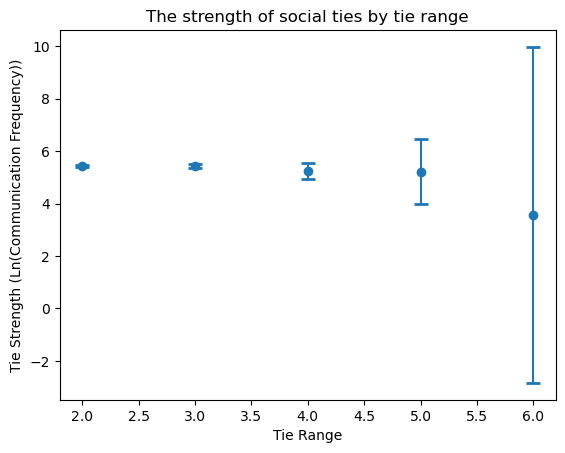

In [27]:
tie_ranges = np.array(tie_ranges)
mean_log_frequencies = np.array(mean_log_frequencies)
confidence_intervals = np.array(confidence_intervals)
plt.errorbar(tie_ranges, mean_log_frequencies, yerr=confidence_intervals, fmt='o', capsize=5, capthick=2)
plt.xlabel('Tie Range')
plt.ylabel('Tie Strength (Ln(Communication Frequency))')
plt.title('The strength of social ties by tie range')
plt.show()
